# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [2]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
train_set

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [4]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))

Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


In [5]:
n_classes


10

### Show example images

Run multiple times to see different examples.

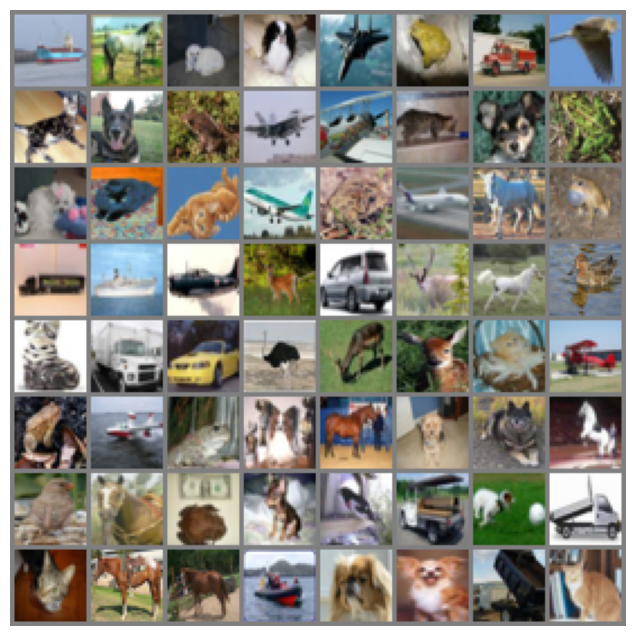

In [6]:
# Get random training images and show them.
images, labels = iter(train_loader).next()
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

In [7]:
# Original Image 
image_dim = 32
chanels_in = 3

# After applying 1st Kernel
chanels_out1 = 32
kernel1 = 9
padd1 = 3
image_dim1 = image_dim - kernel1 + 1 + 2*padd1

# After applying 2nd Kernel
chanels_out2 = 64
kernel2 = 7
padd2 = 2 
image_dim2 = image_dim1 - kernel2 + 1 + 2*padd2

# After applying 3th Kernel
chanels_out3 = 128
kernel3 = 5
padd3 = 1
image_dim3 = image_dim2 - kernel3 + 1 + 2*padd3

max_pool = 2
n_features = chanels_out3*((image_dim3)//(max_pool))**2
final_neurons = 180


image_dim, image_dim1, image_dim2, image_dim3, (image_dim3)//(max_pool), n_features

(32, 30, 28, 26, 13, 21632)

In [8]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class Model(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.num_classes = n_classes
        activation_fn = nn.ReLU

        self.net = nn.Sequential(
            nn.Conv2d(chanels_in, chanels_out1, (kernel1, kernel1), padding=padd1),  # (num_chanels, out_chanels, kernel_size, stride, padding)
            
            nn.Conv2d(chanels_out1, chanels_out2, (kernel2, kernel2), padding=padd2),  # (num_chanels, out_chanels, kernel_size, stride, padding)
            
            nn.Conv2d(chanels_out2, chanels_out3, (kernel3, kernel3), padding=padd3),  # (num_chanels, out_chanels, kernel_size, stride, padding)
            
            nn.MaxPool2d((max_pool, max_pool)),
            
            # Vecotrize the image
            nn.Flatten(),  # from (1, channels, height, width) to (1, channels * height * width)
            
            nn.Linear(n_features, final_neurons),
            activation_fn(),
            nn.Linear(final_neurons, final_neurons),
            activation_fn(),
            nn.Linear(final_neurons, self.num_classes),
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        return self.net(x)


model = Model(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model.to(device)
print(model)

Model(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(3, 3))
    (1): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Linear(in_features=21632, out_features=180, bias=True)
    (6): ReLU()
    (7): Linear(in_features=180, out_features=180, bias=True)
    (8): ReLU()
    (9): Linear(in_features=180, out_features=10, bias=True)
  )
)


## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [9]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [10]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[ 0.00618159 -0.06822488  0.04137356  0.10447041  0.01514756 -0.02419763
   0.10918734 -0.06524771  0.00354378 -0.01660207]
 [ 0.02581955 -0.09174519  0.05831461  0.12195947  0.03658585 -0.01203343
   0.11349715 -0.07627875  0.01276477  0.01782713]]
Output probabilities:
[[0.09939491 0.09226773 0.10295509 0.10966055 0.10029009 0.09642078
  0.11017904 0.09254283 0.09913307 0.09715594]
 [0.10029739 0.0891727  0.10361008 0.11041871 0.10138305 0.09657179
  0.10948825 0.0905626  0.09899653 0.09949896]]


In [11]:
batch_size = 64
num_epochs = 4
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass, compute gradients, perform one training step.
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
     
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"             test accuracy: {valid_accuracies[-1]}")

print("Finished training.")

Step 500     training accuracy: 0.41225
             test accuracy: 0.4872
Step 1000    training accuracy: 0.5998423165137615
             test accuracy: 0.586
Step 1500    training accuracy: 0.6119375
             test accuracy: 0.6197
Step 2000    training accuracy: 0.676605504587156
             test accuracy: 0.6359
Step 2500    training accuracy: 0.7486810064935064
             test accuracy: 0.6476
Step 3000    training accuracy: 0.7180625
             test accuracy: 0.6513
Finished training.


## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

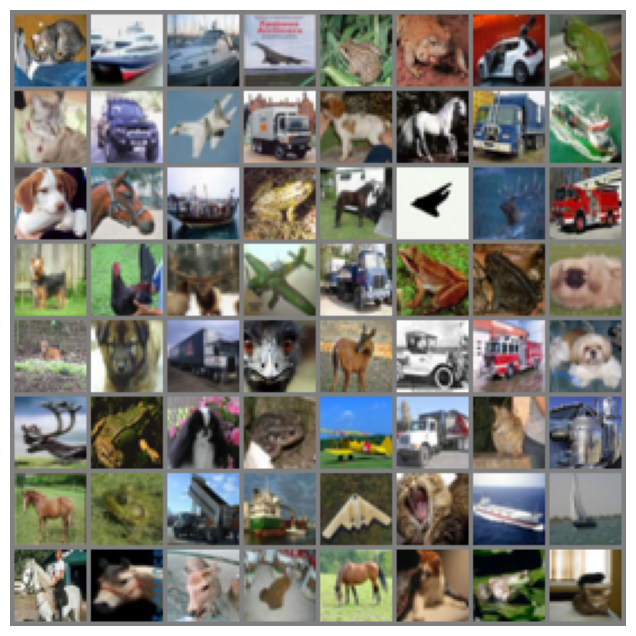

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship       automobile  
    ship       automobile  
  airplane      airplane   
    frog          deer     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           dog     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           dog     
    horse         horse    
    truck         truck    
    ship          ship     
     dog           dog     
    horse          dog     
    ship          ship     
    frog          frog     
    horse         horse    
  airplane      airplane   
    deer        airplane   
    truck         truck    
     dog          deer     
    bird          deer     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog          bird     
     dog           dog     
    deer          bird     
     dog           d

In [12]:
inputs, targets = iter(test_loader).next()
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [13]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [14]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.654


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


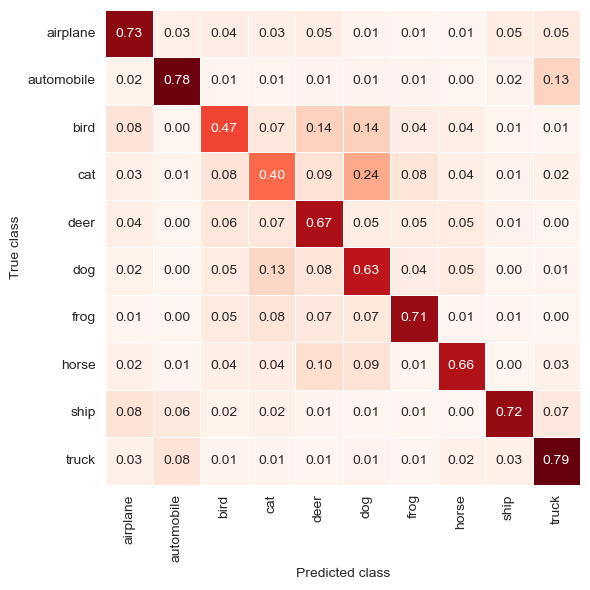

In [15]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

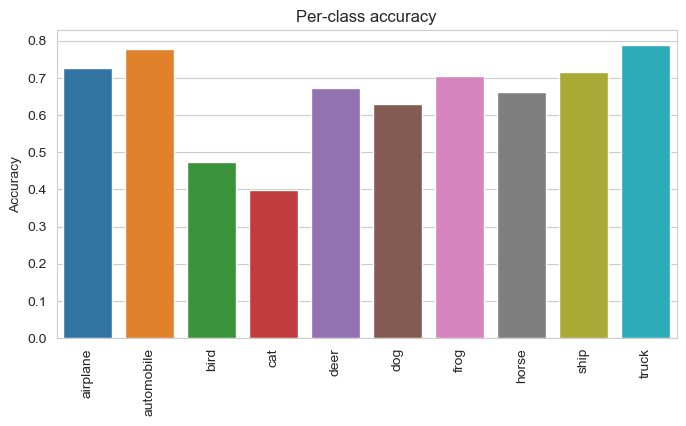

In [16]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

### Result 
You will see in the next cells the Conv Neural Networs I've tried. I've run them in another script or in google collab. The last model has an overal acuracy of more than 70%.



### Model 2

In [20]:
# Original Image 
image_dim = 32
chanels_in = 3

# After applying 1st Kernel
chanels_out1 = 32
kernel1 = 9
padd1 = 4
image_dim1 = image_dim - kernel1 + 1 + 2*padd1

# Max pool: 1st
max_pool1 = 2
image_dim1_p = image_dim1//max_pool1

# After applying 2nd Kernel
chanels_out2 = 64
kernel2 = 7
padd2 = 3
image_dim2 = image_dim1_p - kernel2 + 1 + 2*padd2

# Max pool: 2nd
max_pool2 = 2
image_dim2_p =  image_dim2//max_pool2

# After applying 3th Kernel
chanels_out3 = 128
kernel3 = 5
padd3 = 2
image_dim3 = image_dim2_p - kernel3 + 1 + 2*padd3

# kernel 4
chanels_out4 = 256
kernel4 = 3 
padd4 = 1
image_dim4 = image_dim3 - kernel4 + 1 + 2*padd4 

# kernel 5
chanels_out5 = 256
kernel5 = 3 
padd5 = 1
image_dim5 = image_dim3 - kernel4 + 1 + 2*padd4 

# Max pool: 3th
max_pool3 = 2
image_dim5_p = image_dim4//max_pool2

# Calculate the number of neurons 
n_features = chanels_out4*(image_dim5_p)**2  # n_features it's the input in for the neral network

# Hidden Layers 
hidden_units = [800, 400]
final_neurons = 200

class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class Model2(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.num_classes = n_classes
        activation_relu = nn.ReLU
        activation_elu = nn.ELU
        activation_sig = nn.Sigmoid
        activation_sof = nn.Softmax

        self.net = nn.Sequential(

            # CONVOLUTION PART
            
            # Conv 1st Kernel + ReLU 
            nn.Conv2d(chanels_in, chanels_out1, (kernel1, kernel1), padding=padd1),  # (num_chanels, out_chanels, kernel_size, stride, padding)
            activation_relu(),
            # Max Pooling + Conv 2nd Kernel + Relu
            nn.MaxPool2d((max_pool1,max_pool1)),
            nn.Conv2d(chanels_out1, chanels_out2, (kernel2, kernel2), padding=padd2),  # (num_chanels, out_chanels, kernel_size, stride, padding)
            activation_relu(),
            # Max Pooling + Conv 3th Kernel + Relu
            nn.MaxPool2d((max_pool2, max_pool2)),
            nn.Conv2d(chanels_out2, chanels_out3, (kernel3, kernel3), padding=padd3),  # (num_chanels, out_chanels, kernel_size, stride, padding)
            activation_relu(),
            # Conv 4th Kenrel + Relu + Dropout
            nn.Conv2d(chanels_out3, chanels_out4, (kernel4, kernel4), padding=padd4),
            activation_relu(),
            nn.Dropout(p=0.2, inplace=False),
            # Conv 5th Kenrel + Relu
            nn.Conv2d(chanels_out4, chanels_out5, (kernel5,kernel5), padding=padd5),
            activation_relu(),
            # Max Pool and Flatten 
            nn.MaxPool2d((max_pool3, max_pool3)),  # Specify the size of the Kernel of the max pooling operation 
            nn.Flatten(),  # from (1, channels, height, width) to (1, channels * height * width)
          
            # DENSE NEURAL NETWORK

            # Input layer  
            nn.Linear(n_features, hidden_units[0]),  # (in_features, out_features)
            activation_relu(),
            # Hidden layer: 1
            nn.Linear(hidden_units[0], hidden_units[1]),
            activation_relu(),
            nn.Dropout(p=0.2, inplace=False),
            # # Hidden layer: 2
            nn.Linear(hidden_units[1], final_neurons),
            activation_relu(),
            nn.Dropout(p=0.3, inplace=False),
            # Output Layer
            nn.Linear(final_neurons, self.num_classes),
                # activation_sof(dim=1)   # Why we don't have to put the softmax? it's already defined ? 
        )

    def forward(self, x):
        return self.net(x)


model2 = Model2(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model2.to(device)
print(model2)

Model2(
  (net): Sequential(
    (0): Conv2d(3, 32, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Dropout(p=0.2, inplace=False)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU()
    (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (14): Flatten(start_dim=1, end_dim=-1)
    (15): Linear(in_features=4096, out_features=800, bias=True)
    (16): ReLU()
    (17): Linear(in_features=800, out_features=400, bias=True)


### Model 3: Run in colab

In [22]:
# Original Image 
image_dim = 32
chanels_in = 3

# Kernel 1
chanels_out1 = 32
kernel1 = 3
padd1 = 1
image_dim1 = image_dim - kernel1 + 1 + 2*padd1

# Kernel 2
chanels_out2 = 64
kernel2 = 3
padd2 = 1
image_dim2 = image_dim1 - kernel2 + 1 + 2*padd2

# Max pool: 1st
max_pool1 = 2
image_dim2_p = image_dim2//max_pool1

# Kernel 3
chanels_out3 = 128
kernel3 = 3
padd3 = 1
image_dim3 = image_dim2_p - kernel3 + 1 + 2*padd3

# kernel 4
chanels_out4 = 128
kernel4 = 3 
padd4 = 1
image_dim4 = image_dim3 - kernel4 + 1 + 2*padd4 

# Max pool: 2st
max_pool2 = 2
image_dim4_p = image_dim4//max_pool2

# kernel 5
chanels_out5 = 256
kernel5 = 3 
padd5 = 1
image_dim5 = image_dim4_p - kernel5 + 1 + 2*padd5 

# kernel 6
chanels_out6 = 256
kernel6 = 3 
padd6 = 1
image_dim6 = image_dim5 - kernel6 + 1 + 2*padd6

# Max pool: 3nd
max_pool3 = 2
image_dim6p =  image_dim6//max_pool3


# Calculate the number of neurons 
# n_features = chanels_out4*(image_dim5_p)**2  # n_features it's the input in for the neral network
n_features = 4096
# Hidden Layers 
hidden_units = [1024, 512]


class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x

class Model2(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.num_classes = n_classes
        activation_relu = nn.ReLU
        activation_elu = nn.ELU
        activation_sig = nn.Sigmoid
        activation_sof = nn.Softmax

        self.conv_layer = nn.Sequential(

            # CONVOLUTION PART
            
            # Conv 1st Kernel + Batch norm + ReLU 
            nn.Conv2d(chanels_in, chanels_out1, (kernel1, kernel1), padding=padd1),  # (num_chanels, out_chanels, kernel_size, stride, padding)
            nn.BatchNorm2d(chanels_out1),
            activation_relu(),

            # Conv 2nd Kernel + ReLU + max pool
            nn.Conv2d(chanels_out1, chanels_out2, (kernel2, kernel2), padding=padd2),  # (num_chanels, out_chanels, kernel_size, stride, padding)
            activation_relu(),
            nn.MaxPool2d((max_pool1,max_pool1), stride=2),

            # Conv 3th Kernel + Batch norm + ReLU
            nn.Conv2d(chanels_out2, chanels_out3, (kernel3, kernel3), padding=padd3),  # (num_chanels, out_chanels, kernel_size, stride, padding)
            nn.BatchNorm2d(chanels_out3),
            activation_relu(),

            # Conv 4th Kernel + ReLU + Maxpool + dropout
            nn.Conv2d(chanels_out3, chanels_out4, (kernel4, kernel4), padding=padd4),  # (num_chanels, out_chanels, kernel_size, stride, padding)
            activation_relu(),
            nn.MaxPool2d((max_pool2,max_pool2), stride=2),
            nn.Dropout2d(p=0.05),

            # Conv 5th Kernel + batch norm + ReLU
            nn.Conv2d(chanels_out4, chanels_out5, (kernel5, kernel5), padding=padd5),
            nn.BatchNorm2d(chanels_out5),
            activation_relu(),

            # Conv 6th Kernel
            nn.Conv2d(chanels_out5, chanels_out6, (kernel6, kernel6), padding=padd6),
            activation_relu(),
            nn.MaxPool2d((max_pool3,max_pool3), stride=2),

            # Flatten 
            nn.Flatten(),
        )

        self.dense_layer = nn.Sequential(
            
            # Input Layer
            nn.Dropout(p=0.1),
            nn.Linear(n_features, hidden_units[0]),  # (in_features, out_features)
            activation_relu(),

            # Hidden layer: 1
            nn.Linear(hidden_units[0], hidden_units[1]),
            activation_relu(),
            nn.Dropout(p=0.1),

             # Hidden layer 2:
            nn.Linear(hidden_units[1], hidden_units[2]),
            activation_relu(),
            nn.Dropout(p=0.1),

            # Output Layer
            nn.Linear(hidden_units[1], self.num_classes),
                # activation_sof(dim=1)   # Why we don't have to put the softmax? it's already defined ? 
        )

    def forward(self, x):
        # Apply convolution step 
        x = self.conv_layer(x)

        # Apply dense NN
        x = self.dense_layer(x)


        return x


model2 = Model2(n_classes)
device = torch.device('cpu')  # use cuda or cpu
model2.to(device)
print(model2)

Model2(
  (conv_layer): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
    (12): Dropout2d(p=0.05, inplace=False)
    (13): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): 


2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

### Result 
The first Model it's a the simpler model with 3 convolution layers a max pool and a dense neural network. It has an overall accuracy of 65% aprox. In order to increase the accuracy I read about the subject and tried to recreate the AlexNet model with less layers due to the run time that comes with the complexity increment. 

Model 2: 
Batch size: 64 
epochs: 4

    CONVOLUTIONAL PART:
        Conv 1st Kernel + ReLU 
        Max Pooling + Conv 2nd Kernel + Relu
        Max Pooling + Conv 3th Kernel + Relu
        Conv 4th Kenrel + Relu + Dropout
        Conv 5th Kenrel + Relu
        Max Pool and Flatten 

    DENSE NEURAL NETWORK:
        Input layer (4096, 800)
        Hidden layer: 1 (800, 400)
        Hidden layer: 2 (400, 200)
        Output Layer (200,10)


Basically added activation functions in each convolution to give a non-linear approach. Reglaritzation with the dropout function and 2 hidden layers.

Model 3:
Batch size: 60 
epochs: 30

    CONVOLUTION PART:            
        Conv 1st Kernel + Batch norm + ReLU 
        Conv 2nd Kernel + ReLU + max pool
        Conv 3th Kernel + Batch norm + ReLU
        Conv 4th Kernel + ReLU + Maxpool + dropout
        Conv 5th Kernel + batch norm + ReLU
        Conv 6th Kernel + ReLU + Max Pool
        Flatten 

    DENSE LAYER: (all of )
        Input Layer (4096, 1024)
        Hidden Layer 1 + DropOut: (1024,512)
        Hidden Layer 2 + DropOut: (512, 256)
        Ouput Layer: (256, 10)


SGD optimazer was tryed here

Similar as the other model, has one more convolution layer plus another way of normalization: Batch Normalization. Has the model gows in complexity it's easier to end up overfitting the model so we must considerate regularitzation.           



3. Write down key lessons/insights you got during this exercise.

### Result
Aditionally, as the complexety of the model grows we need more number of epochs to fitt the model. Also we need to add regularitzation terms or we'll end up overfitting the model. Not more number of hidden units will end up giving a better model.

# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [18]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

Available CUDA devices: []


You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

**Answer:**





An extreme version of gradient descent is to use a mini-batch size of just 1. That is, given a training input, x, we update our weights and biases according to the rules 
$$
wk→w′k=wk−η∂Cx/∂wk \\ bl→b′l=bl−η∂Cx/∂bl. 
$$
Then we choose another training input, and update the weights and biases again. And so on, repeatedly. This procedure is known as online, on-line, or incremental learning. In online learning, a neural network learns from just one training input at a time (just as human beings do). Name one advantage and one disadvantage of online learning, compared to stochastic gradient descent with a mini-batch size of, say, 20. 

## Result

One advantage could be:
* By using only a mini-batch of just 1 size, learning would be much faster (computing minima would also be faster)

One disadvantage could be:
* that by using a small mini-batch the approxiation of the gradient might be quite off, so the same happens with the gradient descent direction. 

The story is the same with a mini-batch sized of 20. Compared to the whole dataset and regarding the type of learning, a mini-batch sized of 20, could be considered too small.